In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# PyMC3 extras

*exoplanet* comes bundled with a few utilities that can make it easier to use and debug PyMC3 models for fitting exoplanet data.
This tutorial briefly describes these features and their use.

## Dense mass matrices

The main extra is the :func:`exoplanet.get_dense_nuts_step` function that extends the PyMC3 sampling procedure to include support for learning off-diagonal elements of the mass matrix.
This is *very* important for any problems where there are covariances between the parameters (this is true for pretty much all exoplanet models).
A thorough discussion of this [can be found elsewhere online](https://dfm.io/posts/pymc3-mass-matrix/), but here is a simple demo where we sample a covariant Gaussian using :func:`exoplanet.get_dense_nuts_step`.

First, we generate a random positive definite covariance matrix for the Gaussian:

In [3]:
import numpy as np

ndim = 5
np.random.seed(42)
L = np.random.randn(ndim, ndim)
L[np.diag_indices_from(L)] = 0.1 * np.exp(L[np.diag_indices_from(L)])
L[np.triu_indices_from(L, 1)] = 0.0
cov = np.dot(L, L.T)

And then we can sample this using PyMC3 and :func:`exoplanet.get_dense_nuts_step`:

In [4]:
import pymc3 as pm
import exoplanet as xo

with pm.Model() as model:
    pm.MvNormal("x", mu=np.zeros(ndim), chol=L, shape=(ndim,))
    trace = pm.sample(
        tune=2000, draws=2000, chains=2, cores=2, step=xo.get_dense_nuts_step()
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [x]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


This is a little more verbose than the standard use of PyMC3, but the performance is several orders of magnitude better than you would get without the mass matrix tuning.
As you can see from the `pymc3.summary`, the autocorrelation time of this chain is about 1 as we would expect for a simple problem like this.

In [5]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x[0],0.001,0.166,-0.289,0.325,0.002,0.003,6970.0,1688.0,6997.0,3068.0,1.0
x[1],-0.014,0.529,-0.993,0.979,0.006,0.008,7772.0,1953.0,7686.0,3020.0,1.0
x[2],0.008,0.665,-1.243,1.216,0.008,0.011,7725.0,1884.0,7766.0,3075.0,1.0
x[3],0.019,1.182,-2.315,2.103,0.014,0.019,7597.0,1965.0,7600.0,3100.0,1.0
x[4],0.008,2.061,-3.881,3.675,0.025,0.037,6547.0,1572.0,6517.0,3049.0,1.0


## Evaluating model components for specific samples

I find that when I'm debugging a PyMC3 model, I often want to inspect the value of some part of the model for a given set of parameters.
As far as I can tell, there isn't a simple way to do this in PyMC3, so *exoplanet* comes with a hack for doing this: :func:`exoplanet.eval_in_model`.
This function handles the mapping between named PyMC3 variables and the input required by the Theano function that can evaluate the requested variable or tensor.

As a demo, let's say that we're fitting a parabola to some data:

In [6]:
np.random.seed(42)
x = np.sort(np.random.uniform(-1, 1, 50))
with pm.Model() as model:
    logs = pm.Normal("logs", mu=-3.0, sd=1.0)
    a0 = pm.Normal("a0")
    a1 = pm.Normal("a1")
    a2 = pm.Normal("a2")
    mod = a0 + a1 * x + a2 * x ** 2

    # Sample from the prior
    prior_sample = pm.sample_prior_predictive(samples=1)
    y = xo.eval_in_model(mod, prior_sample)
    y += np.exp(prior_sample["logs"]) * np.random.randn(len(y))

    # Add the likelihood
    pm.Normal("obs", mu=mod, sd=pm.math.exp(logs), observed=y)

    # Fit the data
    map_soln = xo.optimize()
    trace = pm.sample(cores=2)

optimizing logp for variables: [a2, a1, a0, logs]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.805104e+02]

1it [00:00, 531.60it/s, logp=-1.805104e+02]

2it [00:00, 491.86it/s, logp=-4.327812e+03]

3it [00:00, 514.49it/s, logp=-8.849792e+01]

4it [00:00, 561.02it/s, logp=-7.626947e-01]

5it [00:00, 608.52it/s, logp=-2.200191e+01]

6it [00:00, 657.47it/s, logp=2.997231e+01] 

7it [00:00, 693.01it/s, logp=-2.236541e+01]

8it [00:00, 717.39it/s, logp=2.773770e+01] 

9it [00:00, 747.32it/s, logp=3.143286e+01]

10it [00:00, 769.55it/s, logp=3.413150e+01]

11it [00:00, 787.27it/s, logp=3.854444e+01]

12it [00:00, 752.34it/s, logp=4.225590e+01]

13it [00:00, 758.23it/s, logp=4.268326e+01]

14it [00:00, 767.11it/s, logp=4.272187e+01]

15it [00:00, 784.68it/s, logp=4.272284e+01]

16it [00:00, 791.18it/s, logp=4.272302e+01]

17it [00:00, 803.86it/s, logp=4.272311e+01]

18it [00:00, 814.64it/s, logp=4.272312e+01]

19it [00:00, 823.06it/s, logp=4.272312e+01]

20it [00:00, 829.10it/s, logp=4.272312e+01]

21it [00:00, 835.84it/s, logp=4.272312e+01]

22it [00:00, 841.96it/s, logp=4.272312e+01]

23it [00:00, 850.87it/s, logp=4.272312e+01]

24it [00:00, 858.29it/s, logp=4.272312e+01]

25it [00:00, 608.35it/s, logp=4.272312e+01]


message: Optimization terminated successfully.
logp: -180.51036900636572 -> 42.72311721910288
Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [a2, a1, a0, logs]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


After running the fit, it might be interesting to look at the predictions of the model.
We could have added a `pymc3.Deterministic` node for eveything, but that can end up taking up a lot of memory and sometimes its useful to be able to experiement with different outputs.
Using :func:`exoplanet.utils.eval_in_model` we can, for example, evaluate the maximum a posteriori (MAP) model prediction on a fine grid:

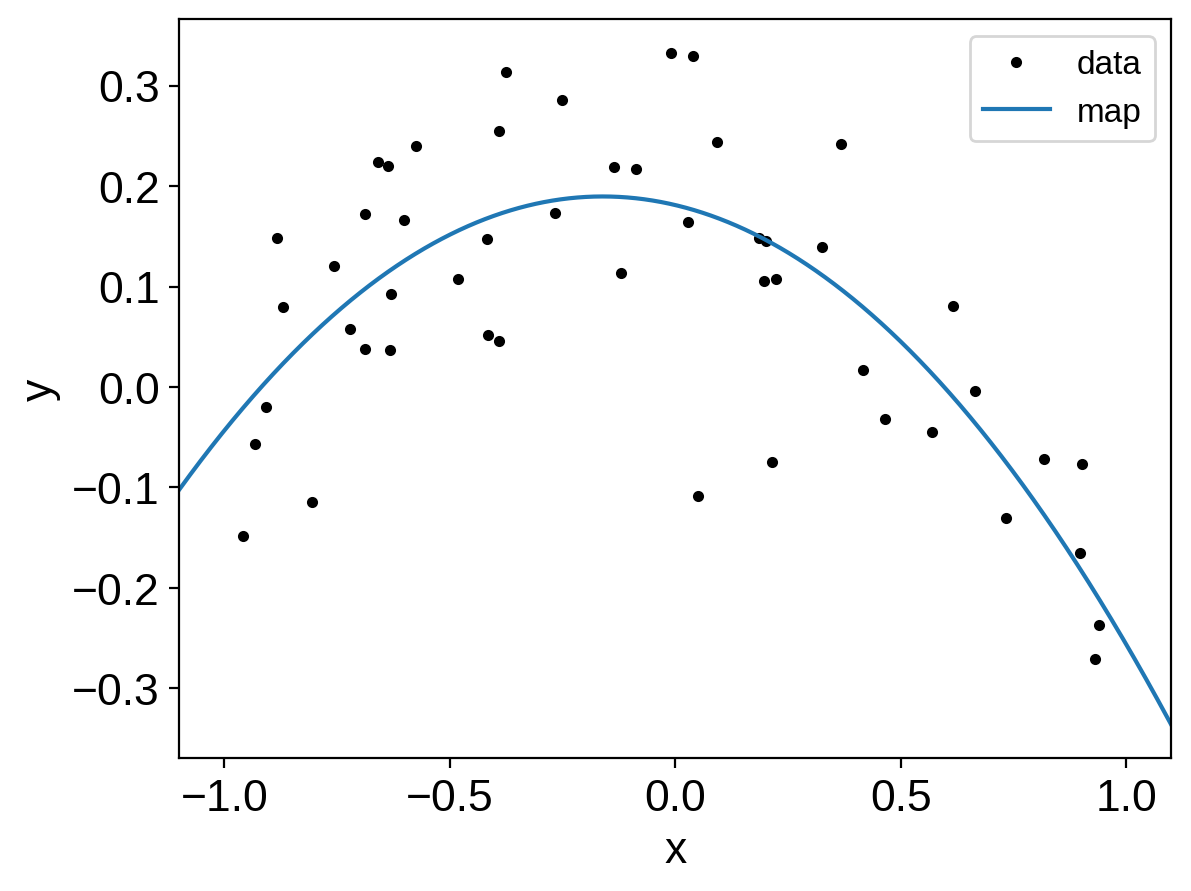

In [7]:
import matplotlib.pyplot as plt

x_grid = np.linspace(-1.1, 1.1, 5000)
with model:
    pred = xo.eval_in_model(a0 + a1 * x_grid + a2 * x_grid ** 2, map_soln)

plt.plot(x, y, ".k", label="data")
plt.plot(x_grid, pred, label="map")
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.xlim(-1.1, 1.1)

We can also combine this with :func:`exoplanet.get_samples_from_trace` to plot this prediction for a set of samples in the trace.

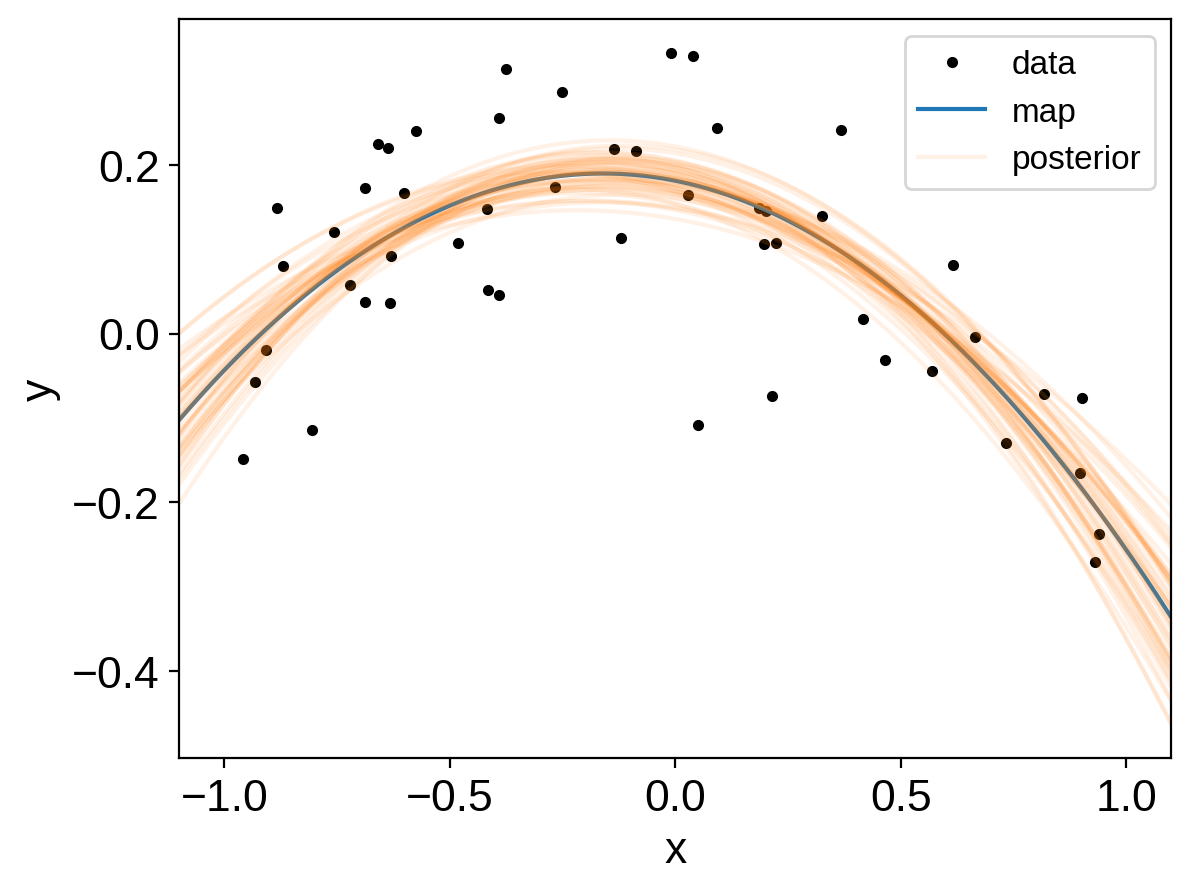

In [8]:
samples = np.empty((50, len(x_grid)))
with model:
    y_grid = a0 + a1 * x_grid + a2 * x_grid ** 2
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=50)):
        samples[i] = xo.eval_in_model(y_grid, sample)

plt.plot(x, y, ".k", label="data")
plt.plot(x_grid, pred, label="map")
plt.plot(x_grid, samples[0], color="C1", alpha=0.1, label="posterior")
plt.plot(x_grid, samples[1:].T, color="C1", alpha=0.1)
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.xlim(-1.1, 1.1)